<a href="https://colab.research.google.com/github/SanaNiroomand/AI-Project-SUT-2025/blob/main/Project_Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names:

Student Numbers:  </font>

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [5]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [6]:
# === Hyperparameters & Paths ===
DATA_DIR = "/content/drive/MyDrive/AI_Project_14032/massachusetts-roads-dataset"  # root of dataset that contains 'tiff/train' and 'tiff/train_labels'
IMAGE_SIZE = (256, 256)   # (W, H)
BATCH_SIZE = 8
NUM_WORKERS = 2
LR = 1e-3
NUM_EPOCHS = 15


# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [7]:
import shutil
import os

# مسیر کش پیش‌فرض KaggleHub در Colab
kagglehub_cache = "/root/.cache/kagglehub"

# اگر وجود داشت، پاکش کن
if os.path.exists(kagglehub_cache):
    shutil.rmtree(kagglehub_cache)
    print("✅ تمام کش KaggleHub پاک شد.")
else:
    print("ℹ️ هیچ کشی پیدا نشد.")

# دوباره پوشه خالی بساز (اختیاری)
os.makedirs(kagglehub_cache, exist_ok=True)

dataset_cache_dir = "/root/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset"

# اگر وجود داشته باشه، پاکش کن
if os.path.exists(dataset_cache_dir):
    shutil.rmtree(dataset_cache_dir)
    print("✅ همه نسخه‌های کش شده حذف شدند.")
else:
    print("ℹ️ دیتاستی در کش پیدا نشد.")

# حالا دوباره دانلود کن
import kagglehub

path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")
print("📂 مسیر دیتاست:", path)

ℹ️ هیچ کشی پیدا نشد.
ℹ️ دیتاستی در کش پیدا نشد.
📂 مسیر دیتاست: /kaggle/input/massachusetts-roads-dataset


If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [8]:
from google.colab import drive
import shutil
import os

# اتصال به گوگل درایو
drive.mount('/content/drive', force_remount=True)

# مسیر مبدا و مقصد
src = "/kaggle/input/massachusetts-roads-dataset"
dst = "/content/drive/MyDrive/AI_Project_14032/massachusetts-roads-dataset"

# اگر مسیر مقصد وجود داشت، کامل پاکش کن
if os.path.exists(dst):
    shutil.rmtree(dst)  # حذف کل پوشه با محتویاتش

# کپی کل پوشه از مبدا به مقصد
shutil.copytree(src, dst)

print("✅ دیتاست با موفقیت به Google Drive کپی شد و اگر قبلاً بود پاک شد.")


Mounted at /content/drive
✅ دیتاست با موفقیت به Google Drive کپی شد و اگر قبلاً بود پاک شد.


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [9]:
from glob import glob

def load_images_and_masks(images_path, masks_path, image_size):
    '''
    Load and preprocess images and masks.
    Returns images: (N,H,W,3) float32 in [0,1], masks: (N,H,W,1) float32 in {0,1}
    '''
    img_files = sorted([f for f in glob(os.path.join(images_path, '*')) if os.path.isfile(f)])
    msk_files = sorted([f for f in glob(os.path.join(masks_path,  '*')) if os.path.isfile(f)])

    if len(img_files) != len(msk_files):
        msk_map = {os.path.splitext(os.path.basename(p))[0]: p for p in msk_files}
        aligned_imgs, aligned_msks = [], []
        for p in img_files:
            stem = os.path.splitext(os.path.basename(p))[0]
            if stem in msk_map:
                aligned_imgs.append(p)
                aligned_msks.append(msk_map[stem])
        img_files, msk_files = aligned_imgs, aligned_msks

    images, masks = [], []
    for img_p, msk_p in zip(img_files, msk_files):
        img = Image.open(img_p).convert('RGB').resize(image_size, Image.BILINEAR)
        msk = Image.open(msk_p).convert('L').resize(image_size, Image.NEAREST)

        img = np.asarray(img, dtype=np.float32) / 255.0
        msk = np.asarray(msk, dtype=np.uint8)
        msk = (msk > 0.0).astype(np.float32)
        msk = np.expand_dims(msk, axis=-1)

        images.append(img); masks.append(msk)

    if len(images) == 0:
        raise RuntimeError(f'No image/mask pairs found under {images_path} / {masks_path}')

    return np.stack(images, axis=0), np.stack(masks, axis=0)


train_images_path = os.path.join(DATA_DIR, 'tiff', 'train')
train_masks_path  = os.path.join(DATA_DIR, 'tiff', 'train_labels')

val_images_path = os.path.join(DATA_DIR, 'tiff', 'val')
val_masks_path  = os.path.join(DATA_DIR, 'tiff', 'val_labels')

train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)
val_images,   val_masks   = load_images_and_masks(val_images_path,   val_masks_path,   IMAGE_SIZE)


### Data Visualization

Display the images and their masks for several samples.

In [10]:
def visualize_images_and_masks(images, masks, n=5):
    n = min(n, len(images))
    plt.figure(figsize=(8, 4 * n))
    for i in range(n):
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(images[i])
        plt.axis('off'); plt.title('Image')
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off'); plt.title('Mask')
    plt.tight_layout(); plt.show()


### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [11]:
class RoadDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        msk = self.masks[idx]
        img_pil = Image.fromarray((img*255).astype(np.uint8))
        msk_pil = Image.fromarray((msk.squeeze()*255).astype(np.uint8))

        img_t = self.image_transform(img_pil) if self.image_transform else transforms.ToTensor()(img_pil)
        msk_t = self.mask_transform(msk_pil)  if self.mask_transform  else transforms.ToTensor()(msk_pil)
        msk_t = (msk_t > 0).float()
        return img_t, msk_t

image_transform = transforms.Compose([transforms.ToTensor()])
mask_transform  = transforms.Compose([transforms.ToTensor()])

train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images,   val_masks,   image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)


### Up Convoluitional Block

We use another block to upsample the latent vector.

In [13]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2)
    def forward(self, x):
        return self.upconv(x)


### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, filter=[64,128,256,512]):
        super().__init__()
        f1,f2,f3,f4 = filter
        self.enc1 = ConvBlock(in_channel, f1)
        self.enc2 = ConvBlock(f1, f2)
        self.enc3 = ConvBlock(f2, f3)
        self.enc4 = ConvBlock(f3, f4)
        self.pool = nn.MaxPool2d(2,2)

        self.bottleneck = ConvBlock(f4, f4*2)

        self.up4 = UpConvBlock(f4*2, f4); self.dec4 = ConvBlock(f4*2, f4)
        self.up3 = UpConvBlock(f4, f3);   self.dec3 = ConvBlock(f3*2, f3)
        self.up2 = UpConvBlock(f3, f2);   self.dec2 = ConvBlock(f2*2, f2)
        self.up1 = UpConvBlock(f2, f1);   self.dec1 = ConvBlock(f1*2, f1)

        self.out_conv = nn.Conv2d(f1, out_channel, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        xb = self.bottleneck(self.pool(x4))

        d4 = self.up4(xb); d4 = torch.cat([d4, x4], dim=1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, x3], dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, x2], dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, x1], dim=1); d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return self.act(out)


# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, 1, bias=True),
            nn.BatchNorm2d(f_int)
        )
        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, 1, bias=True),
            nn.BatchNorm2d(f_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, 1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.act = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: سیگنال دیکودر، x: اسکیپ اِنکودر
        psi = self.act(self.w_g(g) + self.w_x(x))
        psi = self.psi(psi)       # [B,1,H,W]
        return x * psi            # وزن‌دهی نقطه‌ای، بدون B×HW×HW



Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionUNet(UNet):
    """
    Attention U-Net ارتقایافته:
    - گِیت توجه قوی‌تر با InstanceNorm + GELU
    - پالایش Channel & Spatial (سبک CBAM) روی اسکیپ‌های گِیت‌شده
    - Dropout سبک در دیکودر برای کاهش overfitting
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64,128,256,512],
                 attn_dropout=0.05, dec_dropout=0.10):
        # ساختار پایه‌ی U-Net (کلاس‌های قبلی شما) را می‌سازد
        super().__init__(in_channel, out_channel, filter_sizes)
        f1, f2, f3, f4 = filter_sizes

        # ---------- گِیت‌های توجه (g از دیکودر، x از اسکیپ) ----------
        def make_gate(c):
            inter = max(8, c // 2)
            g_conv = nn.Sequential(
                nn.Conv2d(c, inter, 1, bias=False),
                nn.InstanceNorm2d(inter, affine=True),
            )
            x_conv = nn.Sequential(
                nn.Conv2d(c, inter, 1, bias=False),
                nn.InstanceNorm2d(inter, affine=True),
            )
            psi = nn.Sequential(
                nn.Conv2d(inter, inter, 3, padding=1, bias=False),
                nn.GELU(),
                nn.Conv2d(inter, 1, 1, bias=True),
                nn.Sigmoid()
            )
            drop = nn.Dropout2d(attn_dropout) if attn_dropout and attn_dropout > 0 else nn.Identity()
            return nn.ModuleDict(dict(g=g_conv, x=x_conv, psi=psi, drop=drop))

        self.gates = nn.ModuleList([
            make_gate(f1),  # برای سطح 1
            make_gate(f2),  # برای سطح 2
            make_gate(f3),  # برای سطح 3
            make_gate(f4),  # برای سطح 4
        ])

        # ---------- اجزای Channel & Spatial attention برای هر اسکیپ ----------
        def make_cbam(c):
            red = max(1, c // 16)
            ca = nn.ModuleDict(dict(
                fc1=nn.Conv2d(c, red, 1, bias=False),
                fc2=nn.Conv2d(red, c, 1, bias=False)
            ))
            sa = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
            return nn.ModuleDict(dict(ca=ca, sa=sa))

        self.cbams = nn.ModuleList([
            make_cbam(f1), make_cbam(f2), make_cbam(f3), make_cbam(f4)
        ])

        # Dropout سبک بعد از هر بلوک دیکودر
        self.dec_drop = nn.Dropout2d(dec_dropout) if dec_dropout and dec_dropout > 0 else nn.Identity()

    def _gate_skip(self, level_idx, dec_feat, skip):
        """اعمال گِیت توجه + CBAM روی اسکیپ‌کانکشن."""
        gate = self.gates[level_idx]
        # گیت
        a = gate.psi(gate.g(dec_feat) + gate.x(skip))
        a = gate.drop(a)
        xg = skip * a

        # Channel attention (SE)
        cb = self.cbams[level_idx]
        w = cb["ca"].fc2(F.relu(cb["ca"].fc1(F.adaptive_avg_pool2d(xg, 1)), inplace=True))
        w = torch.sigmoid(w)
        xg = xg * w

        # Spatial attention
        am = torch.mean(xg, dim=1, keepdim=True)
        mm, _ = torch.max(xg, dim=1, keepdim=True)
        s = torch.sigmoid(cb["sa"](torch.cat([am, mm], dim=1)))
        xg = xg * s
        return xg

    def forward(self, x):
        # ---------- Encoder ----------
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        xb = self.bottleneck(self.pool(x4))

        # ---------- Decoder + Attn ----------
        d4 = self.up4(xb)
        x4g = self._gate_skip(3, d4, x4)
        d4 = self.dec4(torch.cat([d4, x4g], dim=1))
        d4 = self.dec_drop(d4)

        d3 = self.up3(d4)
        x3g = self._gate_skip(2, d3, x3)
        d3 = self.dec3(torch.cat([d3, x3g], dim=1))
        d3 = self.dec_drop(d3)

        d2 = self.up2(d3)
        x2g = self._gate_skip(1, d2, x2)
        d2 = self.dec2(torch.cat([d2, x2g], dim=1))
        d2 = self.dec_drop(d2)

        d1 = self.up1(d2)
        x1g = self._gate_skip(0, d1, x1)
        d1 = self.dec1(torch.cat([d1, x1g], dim=1))
        d1 = self.dec_drop(d1)

        out = self.out_conv(d1)
        return self.act(out)


# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [17]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 1, bias=False),
            nn.BatchNorm2d(out_channel),
        ) if in_channel != out_channel else nn.Identity()
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        return self.act(y + self.shortcut(x))


Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [18]:
class ResidualAttentionUNet(AttentionUNet):
    """
    نسخه‌ی Residual با همان توجه‌های ارتقایافته:
    فقط بلاک‌های کانولوشنی encoder/decoder با ResidualConvBlock جایگزین می‌شوند.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64,128,256,512],
                 attn_dropout=0.05, dec_dropout=0.10):
        super().__init__(in_channel, out_channel, filter_sizes,
                         attn_dropout=attn_dropout, dec_dropout=dec_dropout)
        f1, f2, f3, f4 = filter_sizes

        # جایگزینی بلاک‌ها با نسخه‌ی رزیدوال (تعاریف ResidualConvBlock از قبل در نوت‌بوک شما هست)
        self.enc1 = ResidualConvBlock(in_channel, f1)
        self.enc2 = ResidualConvBlock(f1, f2)
        self.enc3 = ResidualConvBlock(f2, f3)
        self.enc4 = ResidualConvBlock(f3, f4)

        self.bottleneck = ResidualConvBlock(f4, f4 * 2)

        self.dec4 = ResidualConvBlock(f4 * 2, f4)
        self.dec3 = ResidualConvBlock(f3 * 2, f3)
        self.dec2 = ResidualConvBlock(f2 * 2, f2)
        self.dec1 = ResidualConvBlock(f1 * 2, f1)


# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [19]:
### DICE LOSS
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, real):
        pred = pred.contiguous(); real = real.contiguous()
        inter = (pred*real).sum(dim=(2,3))
        denom = pred.sum(dim=(2,3)) + real.sum(dim=(2,3))
        dice = (2*inter + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

class IouLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__(); self.smooth = smooth
    def forward(self, pred, real):
        pred = pred.contiguous(); real = real.contiguous()
        inter = (pred*real).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + real.sum(dim=(2,3)) - inter
        iou = (inter + self.smooth) / (union + self.smooth)
        return 1 - iou.mean()

class OverallLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss  = IouLoss(smooth)
        self.bce_loss  = nn.BCELoss()
    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou  = self.iou_loss(pred, real)
        bce  = self.bce_loss(pred, real)
        return dice, iou, bce, dice+iou+bce


### Training Epoch

Complete the function below to train the model for one epoch.

In [20]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    model.train()
    total = 0.0
    for imgs, masks in tqdm(data_loader, desc='Train', leave=False):
        imgs = imgs.to(device); masks = masks.to(device)
        optimizer.zero_grad()
        pred = model(imgs)
        _, _, _, loss = criterion(pred, masks)
        loss.backward(); optimizer.step()
        if scheduler is not None: scheduler.step()
        total += loss.item()
    return total / max(1, len(data_loader))


Design a function for evaluation after each training phase.

In [21]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    model.eval()
    total = 0.0; iou_s = 0.0; dice_s = 0.0
    with torch.inference_mode():
        for imgs, masks in tqdm(data_loader, desc='Eval', leave=False):
            imgs = imgs.to(device); masks = masks.to(device)
            pred = model(imgs)
            dice_l, iou_l, bce_l, overall_l = criterion(pred, masks)
            total += overall_l.item()
            iou_s  += 1 - iou_l.item()
            dice_s += 1 - dice_l.item()
    n = max(1, len(data_loader))
    return total/n, iou_s/n, dice_s/n


# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [22]:
unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)
# Add a scheduler if you like

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

Iteration 1/15: Train Loss: 2.02 | Val Loss: 1.77 | Iou Score: 0.19 | Dice Score: 0.32


Iteration 2/15: Train Loss: 1.51 | Val Loss: 1.41 | Iou Score: 0.31 | Dice Score: 0.47


Iteration 3/15: Train Loss: 1.30 | Val Loss: 1.37 | Iou Score: 0.36 | Dice Score: 0.52


Iteration 4/15: Train Loss: 1.23 | Val Loss: 1.10 | Iou Score: 0.45 | Dice Score: 0.62


Iteration 5/15: Train Loss: 1.18 | Val Loss: 1.15 | Iou Score: 0.43 | Dice Score: 0.60


Iteration 6/15: Train Loss: 1.16 | Val Loss: 1.11 | Iou Score: 0.45 | Dice Score: 0.62


Iteration 7/15: Train Loss: 1.15 | Val Loss: 1.05 | Iou Score: 0.48 | Dice Score: 0.65


Iteration 8/15: Train Loss: 1.13 | Val Loss: 1.13 | Iou Score: 0.45 | Dice Score: 0.62


Iteration 9/15: Train Loss: 1.13 | Val Loss: 1.02 | Iou Score: 0.49 | Dice Score: 0.65


Iteration 10/15: Train Loss: 1.11 | Val Loss: 0.96 | Iou Score: 0.52 | Dice Score: 0.68


Iteration 11/15: Train Loss: 1.10 | Val Loss: 0.96 | Iou Score: 0.52 | Dice Score: 0.68


Iteration 12/15: Train Loss: 1.10 | Val Loss: 0.99 | Iou Score: 0.50 | Dice Score: 0.67


Iteration 13/15: Train Loss: 1.09 | Val Loss: 0.96 | Iou Score: 0.52 | Dice Score: 0.68


Iteration 14/15: Train Loss: 1.08 | Val Loss: 0.98 | Iou Score: 0.51 | Dice Score: 0.67


Iteration 15/15: Train Loss: 1.07 | Val Loss: 1.01 | Iou Score: 0.50 | Dice Score: 0.66


Now do the same for Attention UNet and Reidual Attention UNet.

In [23]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_ugnet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

Iteration 1/15: Train Loss: 1.96 | Val Loss: 1.48 | Iou Score: 0.28 | Dice Score: 0.43


Iteration 2/15: Train Loss: 1.39 | Val Loss: 1.18 | Iou Score: 0.41 | Dice Score: 0.58


Iteration 3/15: Train Loss: 1.25 | Val Loss: 1.14 | Iou Score: 0.44 | Dice Score: 0.61


Iteration 4/15: Train Loss: 1.20 | Val Loss: 1.26 | Iou Score: 0.40 | Dice Score: 0.57


Iteration 5/15: Train Loss: 1.17 | Val Loss: 1.03 | Iou Score: 0.49 | Dice Score: 0.65


Iteration 6/15: Train Loss: 1.14 | Val Loss: 1.01 | Iou Score: 0.50 | Dice Score: 0.66


Iteration 7/15: Train Loss: 1.13 | Val Loss: 0.98 | Iou Score: 0.51 | Dice Score: 0.67


Iteration 8/15: Train Loss: 1.11 | Val Loss: 1.08 | Iou Score: 0.47 | Dice Score: 0.63


Iteration 9/15: Train Loss: 1.10 | Val Loss: 0.99 | Iou Score: 0.51 | Dice Score: 0.67


Iteration 10/15: Train Loss: 1.10 | Val Loss: 0.97 | Iou Score: 0.52 | Dice Score: 0.68


Iteration 11/15: Train Loss: 1.09 | Val Loss: 0.96 | Iou Score: 0.52 | Dice Score: 0.68


Iteration 12/15: Train Loss: 1.08 | Val Loss: 1.00 | Iou Score: 0.50 | Dice Score: 0.66


Iteration 13/15: Train Loss: 1.07 | Val Loss: 0.99 | Iou Score: 0.51 | Dice Score: 0.67


Iteration 14/15: Train Loss: 1.06 | Val Loss: 1.05 | Iou Score: 0.49 | Dice Score: 0.65


Iteration 15/15: Train Loss: 1.06 | Val Loss: 1.12 | Iou Score: 0.45 | Dice Score: 0.62


For Residual Attention UNet, plot the changes in train and validation loss.

In [24]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

Iteration 1/15: Train Loss: 1.63 | Val Loss: 1.23 | Iou Score: 0.39 | Dice Score: 0.55


Iteration 2/15: Train Loss: 1.26 | Val Loss: 1.10 | Iou Score: 0.46 | Dice Score: 0.63


Iteration 3/15: Train Loss: 1.19 | Val Loss: 1.07 | Iou Score: 0.47 | Dice Score: 0.64


Iteration 4/15: Train Loss: 1.15 | Val Loss: 1.01 | Iou Score: 0.50 | Dice Score: 0.67


Iteration 5/15: Train Loss: 1.12 | Val Loss: 0.99 | Iou Score: 0.50 | Dice Score: 0.67


Iteration 6/15: Train Loss: 1.10 | Val Loss: 0.99 | Iou Score: 0.50 | Dice Score: 0.67


Iteration 7/15: Train Loss: 1.09 | Val Loss: 1.00 | Iou Score: 0.50 | Dice Score: 0.67


Iteration 8/15: Train Loss: 1.09 | Val Loss: 0.99 | Iou Score: 0.51 | Dice Score: 0.67


Iteration 9/15: Train Loss: 1.07 | Val Loss: 0.95 | Iou Score: 0.52 | Dice Score: 0.68


Iteration 10/15: Train Loss: 1.06 | Val Loss: 0.96 | Iou Score: 0.52 | Dice Score: 0.69


Iteration 11/15: Train Loss: 1.05 | Val Loss: 0.95 | Iou Score: 0.52 | Dice Score: 0.69


Iteration 12/15: Train Loss: 1.04 | Val Loss: 0.97 | Iou Score: 0.51 | Dice Score: 0.67


Iteration 13/15: Train Loss: 1.04 | Val Loss: 0.94 | Iou Score: 0.53 | Dice Score: 0.69


Iteration 14/15: Train Loss: 1.02 | Val Loss: 0.92 | Iou Score: 0.54 | Dice Score: 0.70


Iteration 15/15: Train Loss: 1.01 | Val Loss: 0.93 | Iou Score: 0.53 | Dice Score: 0.69


Now Visualize losses.

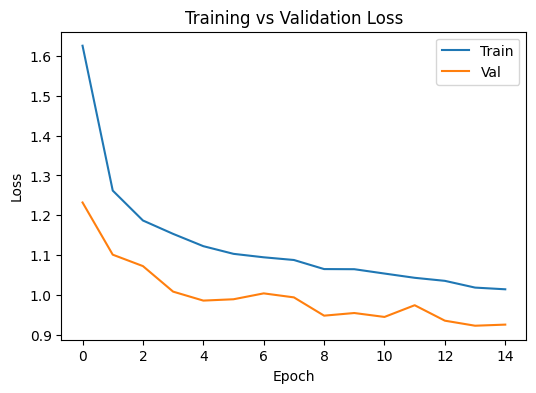

In [25]:
# Plot the losses
if 'train_losses' in globals() and 'val_losses' in globals() and len(train_losses) and len(val_losses):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Training vs Validation Loss'); plt.show()
else:
    print("Run the ResidualAttentionUNet training cell to populate train_losses/val_losses.")


### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

In [26]:
def visualize_image_mask_prediction(images, masks, predictions, n=5):
    n = min(n, len(images))
    plt.figure(figsize=(12, 4*n))
    for i in range(n):
        plt.subplot(n,3,3*i+1); plt.imshow(images[i]); plt.axis('off'); plt.title('Image')
        plt.subplot(n,3,3*i+2); plt.imshow(masks[i].squeeze(), cmap='gray'); plt.axis('off'); plt.title('Mask')
        pr = predictions[i]
        pr = pr.squeeze()
        if pr.ndim == 3: pr = pr[0]
        plt.subplot(n,3,3*i+3); plt.imshow((pr>=0.5).astype(np.float32), cmap='gray'); plt.axis('off'); plt.title('Prediction')
    plt.tight_layout(); plt.show()
